In [8]:
# import libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import matplotlib.pyplot as plt

In [2]:
# load data
train_df = pd.read_pickle("../data/train.pickle")
val_df   = pd.read_pickle("../data/val.pickle")

train_texts = train_df["text"].astype(str).tolist()
val_texts   = val_df["text"].astype(str).tolist()

y_train = train_df[["valence", "arousal"]].values.astype(float)
y_val   = val_df[["valence", "arousal"]].values.astype(float)

In [3]:
# compute embeddings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)

X_train = encoder.encode(
    train_texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

X_val = encoder.encode(
    val_texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(X_train.shape, X_val.shape)  # (N, 384)

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

(2165, 384) (599, 384)


In [4]:
# train model without historical features

ridge = Ridge(alpha=1.0)
reg = MultiOutputRegressor(ridge)
reg.fit(X_train, y_train)

pred = reg.predict(X_val)

rmse_v = np.sqrt(mean_squared_error(y_val[:, 0], pred[:, 0]))
rmse_a = np.sqrt(mean_squared_error(y_val[:, 1], pred[:, 1]))

print(f"Valence RMSE: {rmse_v:.4f}")
print(f"Arousal RMSE: {rmse_a:.4f}")
print(f"Avg RMSE: {(rmse_v + rmse_a) / 2:.4f}")

Valence RMSE: 1.0340
Arousal RMSE: 0.6316
Avg RMSE: 0.8328


In [5]:

def add_history_features(
    df,
    global_v_mean,
    global_a_mean,
):
    # sort by timestamp
    df = df.sort_values(["user_id", "timestamp", "text_id"]).reset_index(drop=True)

    # only use previous labels
    v_prev = df.groupby("user_id")["valence"].shift(1)
    a_prev = df.groupby("user_id")["arousal"].shift(1)

    # pre / last
    df["v_pre"] = v_prev.fillna(global_v_mean)
    df["a_pre"] = a_prev.fillna(global_a_mean)

    # mean so far
    df["v_mean_sofar"] = (
        v_prev.groupby(df["user_id"])
              .expanding()
              .mean()
              .reset_index(level=0, drop=True)
              .fillna(global_v_mean)
    )
    df["a_mean_sofar"] = (
        a_prev.groupby(df["user_id"])
              .expanding()
              .mean()
              .reset_index(level=0, drop=True)
              .fillna(global_a_mean)
    )

    # std so far
    df["v_std_sofar"] = (
        v_prev.groupby(df["user_id"])
              .expanding()
              .std()
              .reset_index(level=0, drop=True)
              .fillna(0.0)
    )
    df["a_std_sofar"] = (
        a_prev.groupby(df["user_id"])
              .expanding()
              .std()
              .reset_index(level=0, drop=True)
              .fillna(0.0)
    )

    # min so far
    df["v_min_sofar"] = (
        v_prev.groupby(df["user_id"])
              .cummin()
              .fillna(global_v_mean)
    )
    df["a_min_sofar"] = (
        a_prev.groupby(df["user_id"])
              .cummin()
              .fillna(global_a_mean)
    )

    # max so far
    df["v_max_sofar"] = (
        v_prev.groupby(df["user_id"])
              .cummax()
              .fillna(global_v_mean)
    )
    df["a_max_sofar"] = (
        a_prev.groupby(df["user_id"])
              .cummax()
              .fillna(global_a_mean)
    )
    
    # pre-residuals
    df["v_pre_res"] = (v_prev - df["v_mean_sofar"]).fillna(0.0)
    df["a_pre_res"] = (a_prev - df["a_mean_sofar"]).fillna(0.0)


    return df


In [6]:
# sort dataframes by user_id, timestamp, text_id for easier lookup later
sort_cols = ["user_id", "timestamp", "text_id"]
train_df = train_df.sort_values(sort_cols).reset_index(drop=True)
val_df   = val_df.sort_values(sort_cols).reset_index(drop=True)

# compute historical features
global_v_mean = float(train_df["valence"].mean())
global_a_mean = float(train_df["arousal"].mean())

train_df = add_history_features(train_df, global_v_mean, global_a_mean)
val_df   = add_history_features(val_df,   global_v_mean, global_a_mean)

hist_cols = [
    "v_pre", "a_pre",
    "v_mean_sofar", "a_mean_sofar",
    "v_std_sofar", "a_std_sofar",
    "v_min_sofar", "a_min_sofar",
    "v_max_sofar", "a_max_sofar",
    "v_pre_res","a_pre_res"
]

# sentence embeddings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)

train_texts = train_df["text"].astype(str).tolist()
val_texts   = val_df["text"].astype(str).tolist()

X_train_emb = encoder.encode(train_texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
X_val_emb   = encoder.encode(val_texts,   batch_size=64, show_progress_bar=True, convert_to_numpy=True)

# concatenate (embedding + history features)
X_train_hist = train_df[hist_cols].astype(float).values
X_val_hist   = val_df[hist_cols].astype(float).values

print("Historical features shape:", X_train_hist.shape, X_val_hist.shape)
X_train = np.hstack([X_train_emb, X_train_hist]).astype(np.float32)
X_val   = np.hstack([X_val_emb,   X_val_hist]).astype(np.float32)

y_train = train_df[["valence","arousal"]].astype(float).values
y_val   = val_df[["valence","arousal"]].astype(float).values

print("X_train:", X_train.shape, "X_val:", X_val.shape)

# train model with historical features
reg = MultiOutputRegressor(Ridge(alpha=1.0, random_state=42))
reg.fit(X_train, y_train)

pred = reg.predict(X_val)

rmse_v = np.sqrt(mean_squared_error(y_val[:, 0], pred[:, 0]))
rmse_a = np.sqrt(mean_squared_error(y_val[:, 1], pred[:, 1]))
mae_v  = mean_absolute_error(y_val[:, 0], pred[:, 0])
mae_a  = mean_absolute_error(y_val[:, 1], pred[:, 1])

print("\n==== Validation Metrics (MiniLM + history + Ridge) ====")
print(f"Valence  RMSE: {rmse_v:.4f} | MAE: {mae_v:.4f}")
print(f"Arousal  RMSE: {rmse_a:.4f} | MAE: {mae_a:.4f}")
print(f"Avg RMSE: {(rmse_v + rmse_a)/2:.4f}")

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Historical features shape: (2165, 12) (599, 12)
X_train: (2165, 396) X_val: (599, 396)

==== Validation Metrics (MiniLM + history + Ridge) ====
Valence  RMSE: 1.0116 | MAE: 0.8216
Arousal  RMSE: 0.6168 | MAE: 0.5136
Avg RMSE: 0.8142


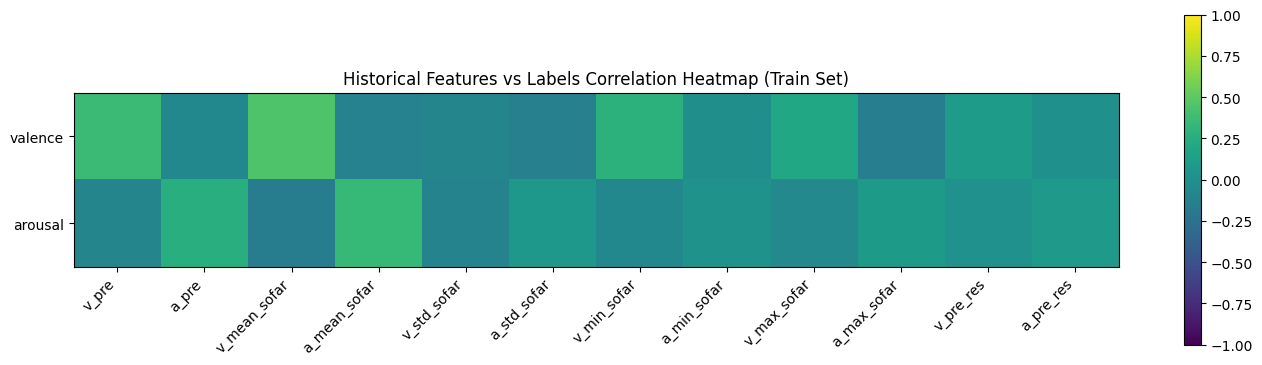

In [9]:
# compute correlations
corr_v = train_df[hist_cols].corrwith(train_df["valence"])
corr_a = train_df[hist_cols].corrwith(train_df["arousal"])

corr_mat = np.vstack([corr_v.values, corr_a.values])

# plot heatmap
plt.figure(figsize=(14, 3.8))
plt.imshow(corr_mat, vmin=-1, vmax=1)
plt.colorbar()

plt.xticks(range(len(hist_cols)), hist_cols, rotation=45, ha="right")
plt.yticks([0, 1], ["valence", "arousal"])

plt.title("Historical Features vs Labels Correlation Heatmap (Train Set)")
plt.tight_layout()
plt.show()